# `Семинар 2.1: Дообучение нейронных`

### `Оганов Александр, кафедра ММП ВМК МГУ`

#### `За основу взяты материалы Глеба Афанасьева, Максима Нахднова, Варламовой Арины, кафедра ММП ВМК МГУ`


В данном ноутбуке рассмотрены некоторые аспекты обучения нейросетей с помощью библиотеки PyTorch. Эксперименты проводятся на датасете **[Tiny ImageNet](https://github.com/fastai/imagenette#imagenette-1)**. 

Официальные туториалы pytorch по этим темам:

* [Neural networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

* [Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)

* [Reproducibilty PyTorch](https://pytorch.org/docs/stable/notes/randomness.html)

* [Training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [1]:
import torch
import torch.nn as nn

## `Напоминание`

**Вопрос:** что мы делали на прошлом семинаре? Какую задачу решали? Что использовали?

## `Простая схема сверточной сети для классификации`

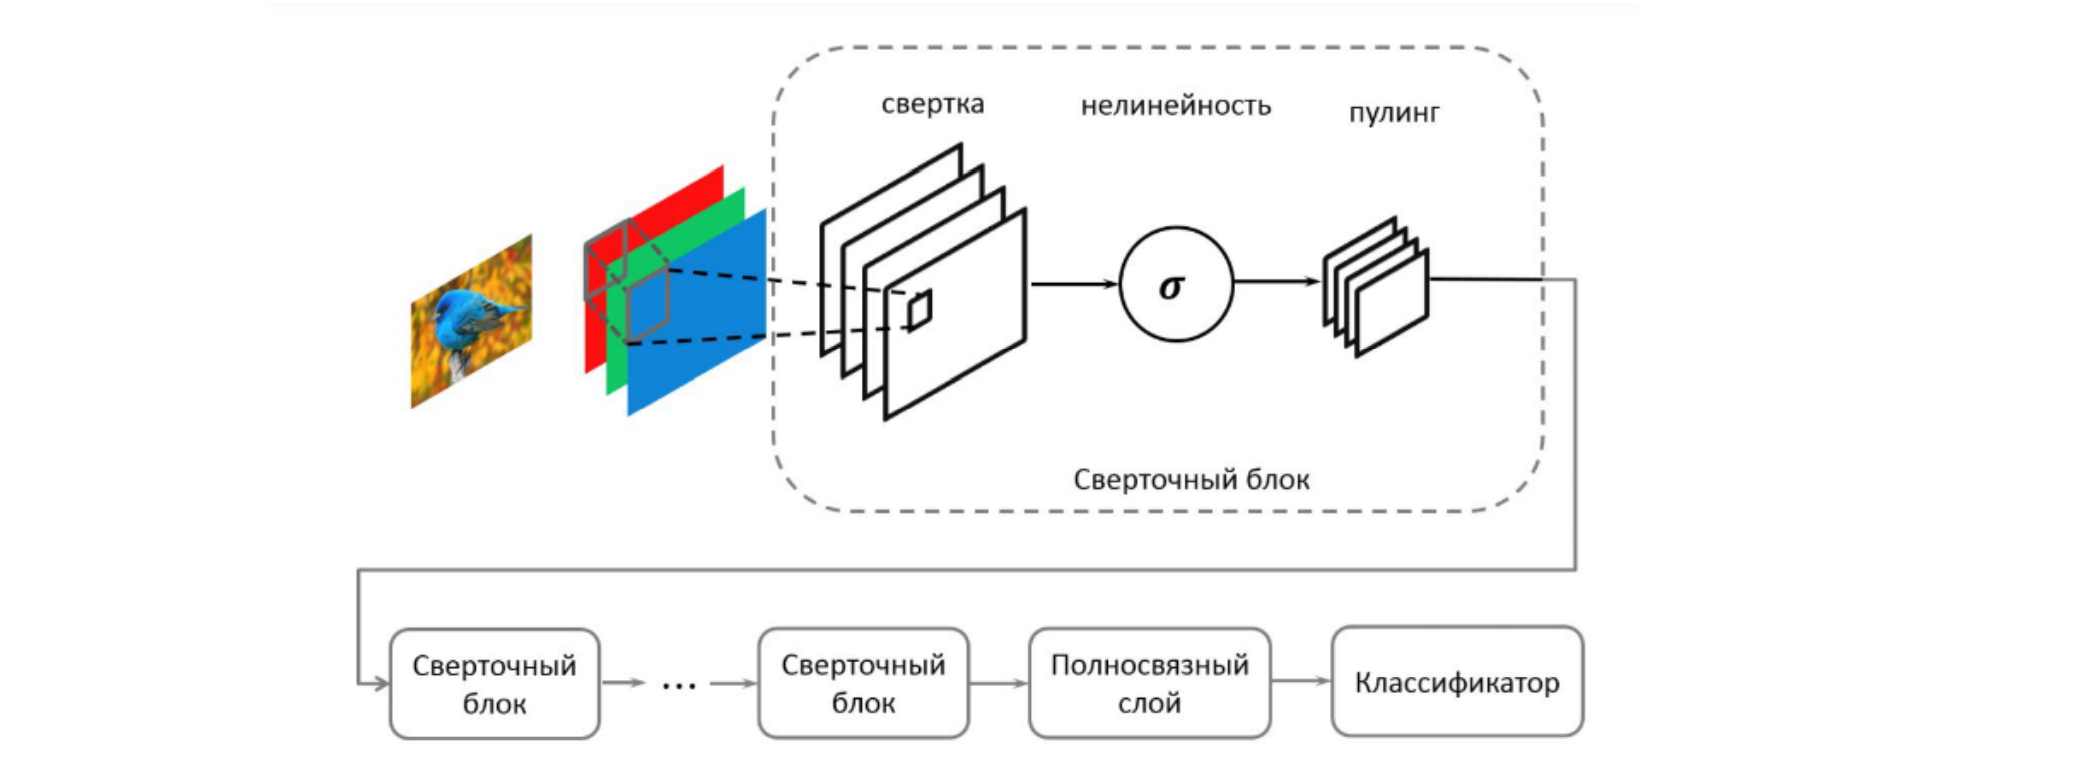

Классические архитектуры сверточных сетей для 
классификации


*   AlexNet
*   VGG
*   Inception
*   ResNet
*   https://pytorch.org/vision/0.8/models.html



### `Архитектура AlexNet`

![title](https://neurohive.io/wp-content/uploads/2018/10/AlexNet-1-1.png)

### `Архитектура VGG16`

![title](https://images.deepai.org/converted-papers/2003.05096/vgg16.png)

### `Resnet 18`

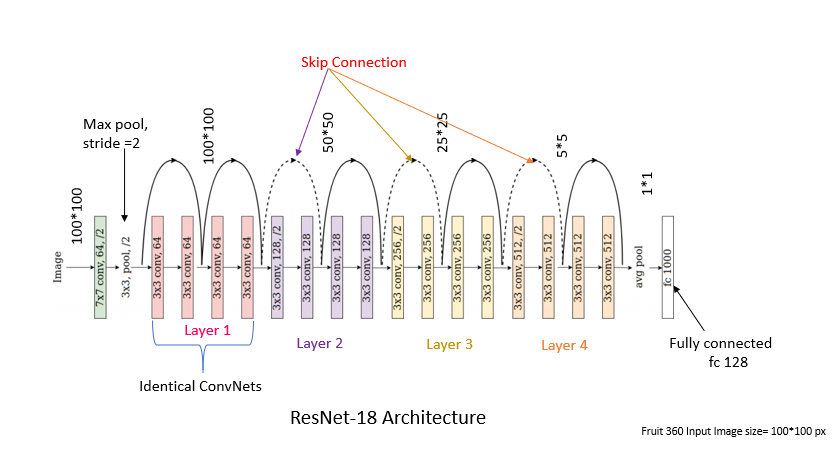

**Задание:** Реализуйте layer 1 согласно диаграмме выше 


## `Вспомогательные функции`

In [2]:
# source https://pytorch.org/docs/stable/notes/randomness.html


def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """
    

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Для Dataloader
    g = torch.Generator()
    g.manual_seed(seed)
    
    return g

# Для каждого woerker в Daaloader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [3]:
def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

In [4]:
@torch.no_grad()
def evaluate(net, valid_dataloader, loss_fn, device):
    net.eval()
    loss, accuracy = 0, 0
    count = 0
    for X_batch, y_true in valid_dataloader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        out = net(X_batch)
        y_pred = torch.argmax(out, 1)
        
        bs = out.shape[0]
        loss += loss_fn(out, y_true).item() * bs
        accuracy += torch.sum(y_pred == y_true).item()
        count += bs
        
    return loss / count, accuracy / count

def train(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device):
    
    wandb.init(project="Imagenette", name=config['name'], config=config)
    global_step = 0
    net = net.to(device)
    
    epoch_num = config['epoch_num']
    for epoch in tqdm(range(epoch_num)):
        net.train()
        
        for X_batch, y_true in train_dataloader:
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            
            out = net(X_batch)
            
            loss = loss_fn(out, y_true)
            loss.backward()
            
            
            optimizer.step()
            
            y_pred = torch.argmax(out, 1)
            accuracy = torch.sum(y_pred == y_true) / y_pred.shape[0]
            
            wandb.log({"train/loss": loss.item(), "train/accuracy": accuracy.item()}, step=global_step)
            
            global_step += 1
        
        loss, accuracy = evaluate(net, valid_dataloader, loss_fn, device)
        wandb.log({"eval/loss": loss, "eval/accuracy": accuracy}, step=global_step)
        
    wandb.finish()

## `Практика`

Рассмотрим датасет `Imagenette`, который состоит из подмножества `ImageNet` и содержит только 10 классов.

`Imagenette` - это подмножество из 10 легко классифицируемых классов `ImageNet` (линь, английский спрингер, кассетный проигрыватель, бензопила, церковь, валторна, мусоровоз, бензонасос, мяч для гольфа, парашют).

[Страница на PyTorch](https://pytorch.org/vision/stable/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette)

[Официальный GitHub](https://github.com/fastai/imagenette#imagenette-1)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

import os
import random

from PIL import Image
from tqdm import tqdm
import wandb

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [6]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda:0"
    
device

'cuda:0'

In [7]:
DATA_DIR = "../day_1/imagenette2-160/"

In [8]:
if not os.path.exists(DATA_DIR):
    DATA_DIR = "./imagenette2-160"
    
    ! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
    !tar -xvzf imagenette2-160.tgz

In [9]:
df = pd.read_csv(os.path.join(DATA_DIR, 'noisy_imagenette.csv'))
df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


In [10]:
enc = OrdinalEncoder()
labels = df['noisy_labels_0'].values
labels_enc = enc.fit_transform(labels[:, None]).astype('int').ravel()

names, counts = np.unique(labels_enc, return_counts=True)
print("Информация о таргетах")
print("Присутсвтуют классы:", names.tolist())
print("Количество объектов каждого класса:", names.tolist())

df['target'] = labels_enc

Информация о таргетах
Присутсвтуют классы: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Количество объектов каждого класса: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
class ImageDataset(Dataset):
    
    def __init__(self, data, is_train, transform):
        super().__init__()
        mask = data['is_valid'] != is_train
        
        self.img_paths = data[mask].path.values
        self.targets = data[mask].target.values
        
        self.transform = transform
        
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = Image.open(os.path.join(DATA_DIR, path)).convert('RGB')
        
        target = self.targets[idx]
        img = self.transform(img)
            
        return img, target
    
    def __len__(self):
        return len(self.targets)

In [12]:
# Почему разные transform?

transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomCrop((160, 160)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomGrayscale(p=0.1)])

transform_test = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop((160, 160))])

In [13]:
train_dataset = ImageDataset(df, is_train=True, transform=transform_train)
valid_dataset = ImageDataset(df, is_train=False, transform=transform_test)
len(train_dataset), len(valid_dataset)

(9469, 3925)

## `Transfer learning`

Для повышения качества можно использовать более мощные архитектуры. К сожалению, чем больше модель, тем сложнее ее учить на малом числе данных. Мы можем воспользовать методом `transfer learning`, то есть обучить модель на большом датасете, например, `ImageNet`, после чего использовать уже найденные веса для обучения на маленьком датасете. 

При использовании `transfer learning` предполагается, что датасеты чем-то похожи и паттерны, которые есть в большом датасете есть и в других задачах.

Существуют 2 основных подходы:

1) `Finetuning`: дообучение всей модели

2) `Linear probing`: заморозка весов всей модели, кроме последнего линейного слоя (классификатора)

### `Модель ResNet18`

In [14]:
from torchvision.models import resnet18, ResNet18_Weights

In [15]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Задание:** Напишите класс обертку для модели resnet

In [16]:
class ResNet18Wrapper(nn.Module):
    def __init__(self, resnet_model):
        super().__init__()
        
        # YOUR CODE HERE
        self.resnet_block = resnet_model
        
    def forward(self, x):
        # YOUR CODE HERE
        
        x = torch.nn.functional.interpolate(x, scale_factor=1)
        x = self.resnet_block(x)

        return x

### `Фиксированные параметры`

In [17]:
config = {"seed": 42, "lr": 1e-4, "epoch_num": 10, 'batch_size': 256, 'name': None}
loss_fn = torch.nn.CrossEntropyLoss()

### `Обучение resnet`

В качестве базового эксперимента мы обучим `resnet` без использования предобученных весов

**Вопрос:** Что мы ожидаем в результате обучение? Будет ли метрика лучше, чем на прошлом семинаре? Удасться ли нам улучшить метрику при finetuning или linear probing? 

Создадим `dataloader` как делали на прошлом семинаре

In [18]:
g = set_global_seed(config['seed'])

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, 
                               num_workers=4, worker_init_fn=seed_worker, generator=g)

valid_dataloader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

Создадим модель с использованием уже готовой архитектуры `resnet`

In [19]:
resnet_model = resnet18()

# Почему делаем так?
resnet_model.fc = torch.nn.Linear(512, 10) 

net = ResNet18Wrapper(resnet_model)

Определим остальные параметры

In [20]:
config['name'] = 'ResNet18_base'
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [21]:
train(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device)

wandb: Currently logged in as: 3145tttt. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████████████| 10/10 [03:30<00:00, 21.05s/it]


eval/accuracy,▁▆▇▇██████
eval/loss,█▂▂▂▁▁▁▁▁▁
train/accuracy,▁▃▃▄▅▄▅▅▆▆▆▆▇▆▆▆▆▆▇▆▇▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇
train/loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁
eval/accuracy,0.70038
eval/loss,0.96523
train/accuracy,0.81818
train/loss,0.5807


## `Finetuning`

Воспользуемся теперь предообученной версией, которую учили на ImageNet с [разными лайфками](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/).

**Вопрос:** Что мы ожидаем? Будет ли улучшение качества?

In [23]:
config['name'] = 'ResNet18_pretrained'

g = set_global_seed(config['seed'])

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, 
                               num_workers=4, worker_init_fn=seed_worker, generator=g)

valid_dataloader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

# Отличие
resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet_model.fc = torch.nn.Linear(512, 10)
net = ResNet18Wrapper(resnet_model)

optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [24]:
print_params_count(resnet_model)

Информация о числе параметров модели: ResNet
Всего параметров: 		 11181642
Всего обучаемых параметров: 	 11181642



In [26]:
train(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device)

100%|█████████████████████████████████████████████████████| 10/10 [03:58<00:00, 23.84s/it]


eval/accuracy,▁▆▇▆█▇██▇▇
eval/loss,█▄▃▂▁▁▁▁▁▁
train/accuracy,▁▆▆▆█▇▇▇██▇█████████████████████████████
train/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.96637
eval/loss,0.10406
train/accuracy,0.99605
train/loss,0.01695


## `Linear probing`

Мы еще раз воспользуемся предобученной моделью, но в этот раз заморозим все слои, кроме последнего линейного?


**Вопрос:** Что мы ожидаем? Будет ли улучшение качества? Сколько будет обучаемых параметров?
    
**Вопрос:** Чему соответствуют обучение последнего линейного слоя?

In [27]:
config['name'] = 'ResNet18_pretrained_lp'

g = set_global_seed(config['seed'])

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, 
                               num_workers=4, worker_init_fn=seed_worker, generator=g)

valid_dataloader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Отличие
for parameter in resnet_model.parameters():
    parameter.requires_grad_(False)
    
resnet_model.fc = torch.nn.Linear(512, 10)
net = ResNet18Wrapper(resnet_model)

optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [28]:
print_params_count(resnet_model)

Информация о числе параметров модели: ResNet
Всего параметров: 		 11181642
Всего обучаемых параметров: 	 5130



In [29]:
train(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device)

100%|█████████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.96s/it]


eval/accuracy,▁▄▆▇▇█████
eval/loss,█▆▅▄▃▂▂▁▁▁
train/accuracy,▁▁▂▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇███▇▇▇███████████████
train/loss,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.92408
eval/loss,0.48051
train/accuracy,0.93281
train/loss,0.49467
